In [1]:
import numpy as np
import random
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from ensemble.distributions import distribution_dict
from ensemble.model import EnsembleFitter, EnsembleDistribution

# data = pd.read_csv("microdata_2024_05_03.csv", encoding="latin-1")
# data["year_id"] = np.around(np.mean(data["year_start"] / data["year_end"]), decimals=1)
# data = data[["nid", "location_id", "year_id", "sex", "age", "age_start3", "fpg_mmol"]]
data = pd.read_parquet("microdata_2024_05_03.parquet")

# Fitting individual distributions

/Users/maxbi/opt/anaconda3/envs/ensemble/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:2509: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


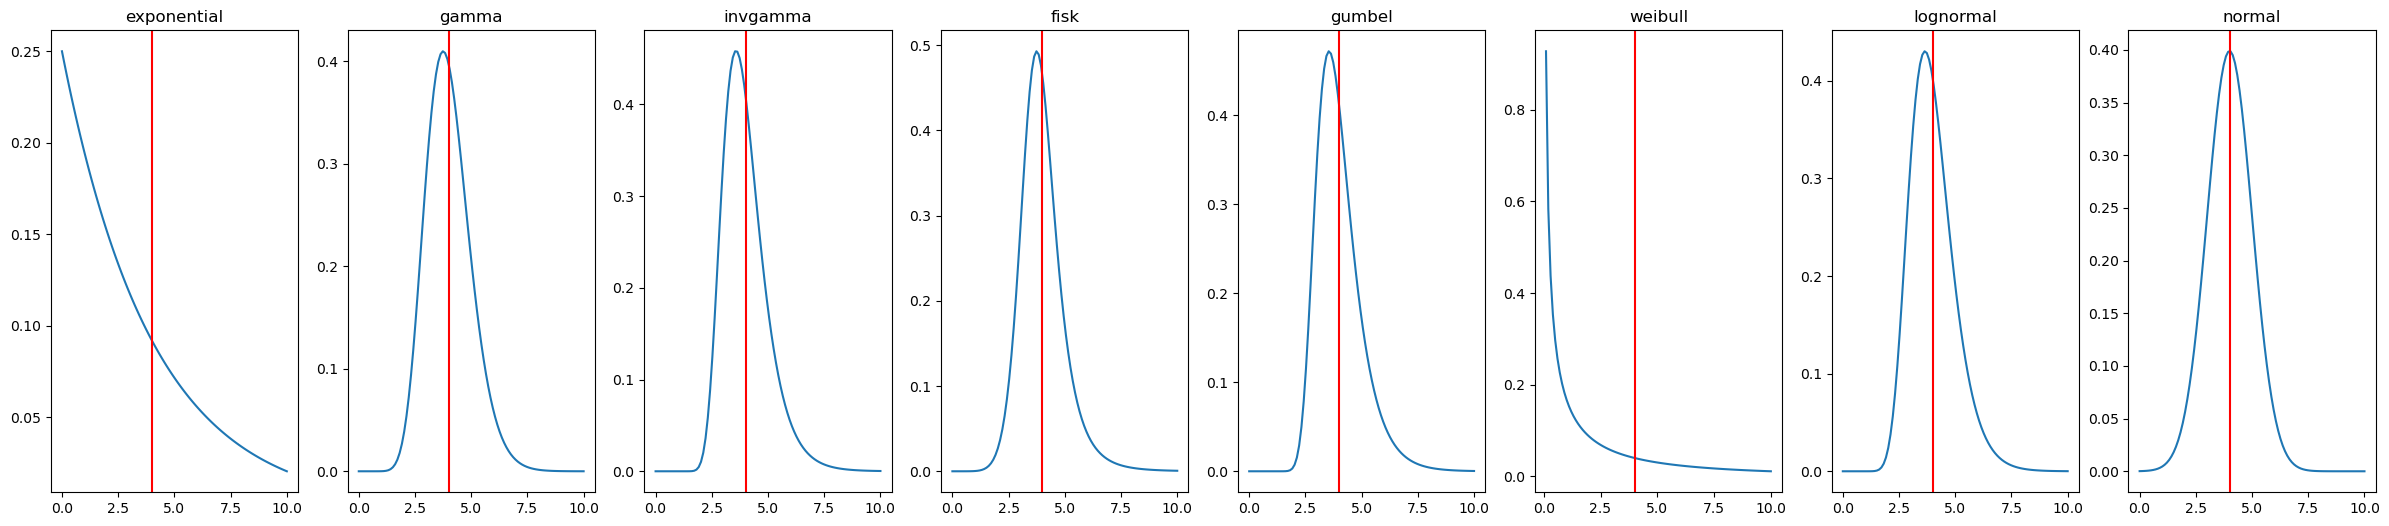

In [2]:
MEAN = 4
VARIANCE = 1
fitted_distributions = {}
counter = 0
fig, ax = plt.subplots(1, len(distribution_dict) - 1, figsize=(30, 6))
for distribution in distribution_dict:
  if distribution != "beta":
    fitted_distributions[distribution] = distribution_dict[distribution](MEAN, VARIANCE)
    support = np.linspace(0, 10, 100)
    pdf = fitted_distributions[distribution].pdf(support)
    ax[counter].plot(support, pdf)
    ax[counter].axvline(MEAN, color="red")
    ax[counter].title.set_text(distribution)
    counter += 1


# Fitting ensemble distributions

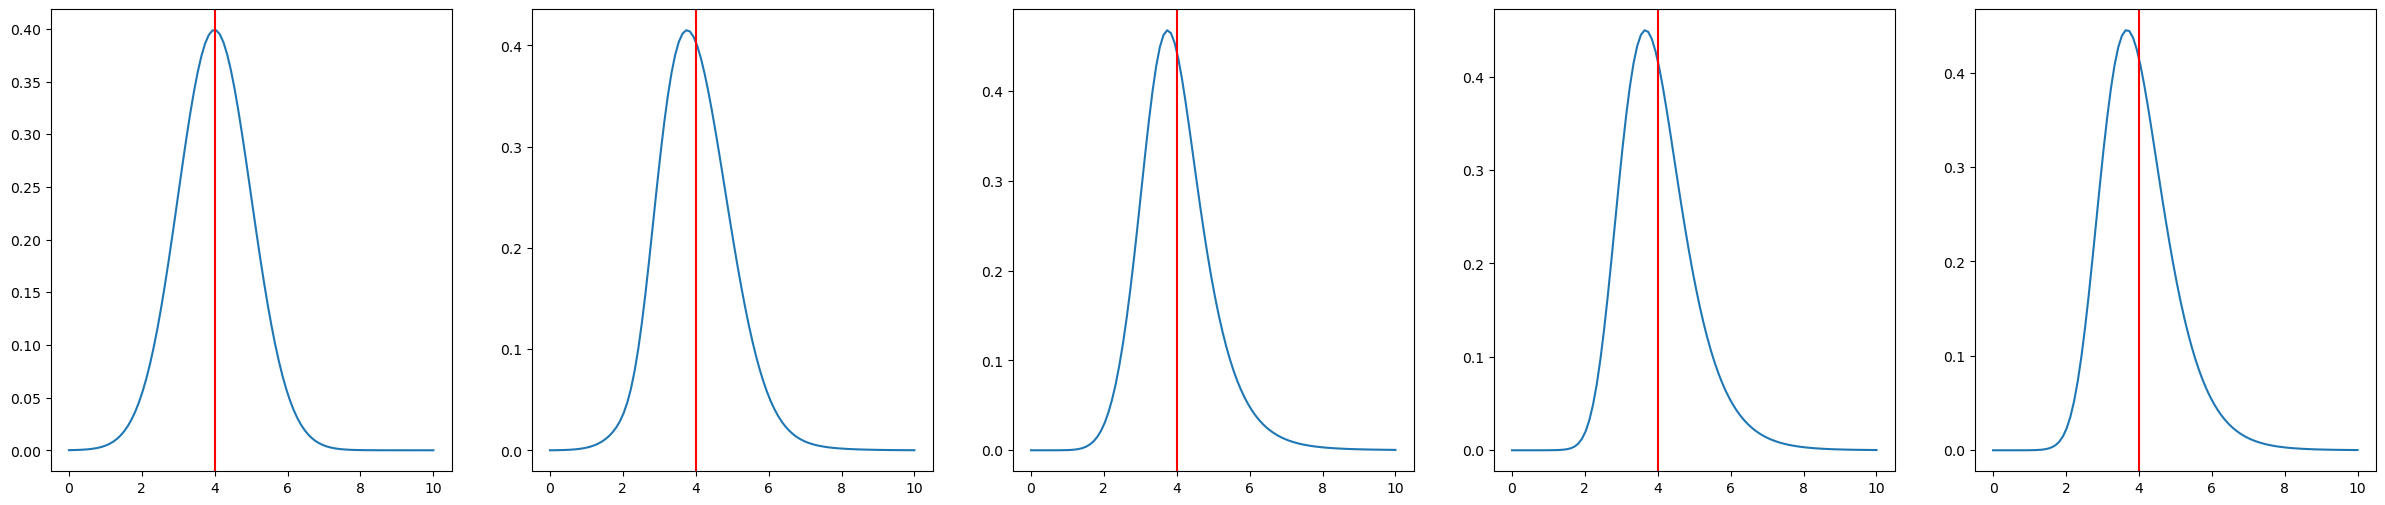

In [3]:
support = np.linspace(0, 10, 100)

def plot_ensembles(distributions, weights, mean, variance, support, figsize):
  fig, ax = plt.subplots(1, len(distributions), figsize=figsize)
  for i in range(len(distributions)):
    mod = EnsembleDistribution(distributions[i], weights[i], mean, variance)
    pdf = mod.pdf(support)
    ax[i].plot(support, pdf)
    ax[i].axvline(mean, color="red")

distributions = [["normal", "gumbel"],
                 ["normal", "gumbel"],
                 ["gamma", "fisk"],
                 ["invgamma", "lognormal", "fisk"],
                 ["gamma", "invgamma", "lognormal", "fisk"]]

weights = [[0.99, 0.01], [0.6, 0.4], [0.3, 0.7], [0.3, 0.5, 0.2], [0.2, 0.3, 0.3, 0.2]]

plot_ensembles(distributions, weights, MEAN, VARIANCE, support, (30, 6))

# Comparing fitted ensemble distributions to truth

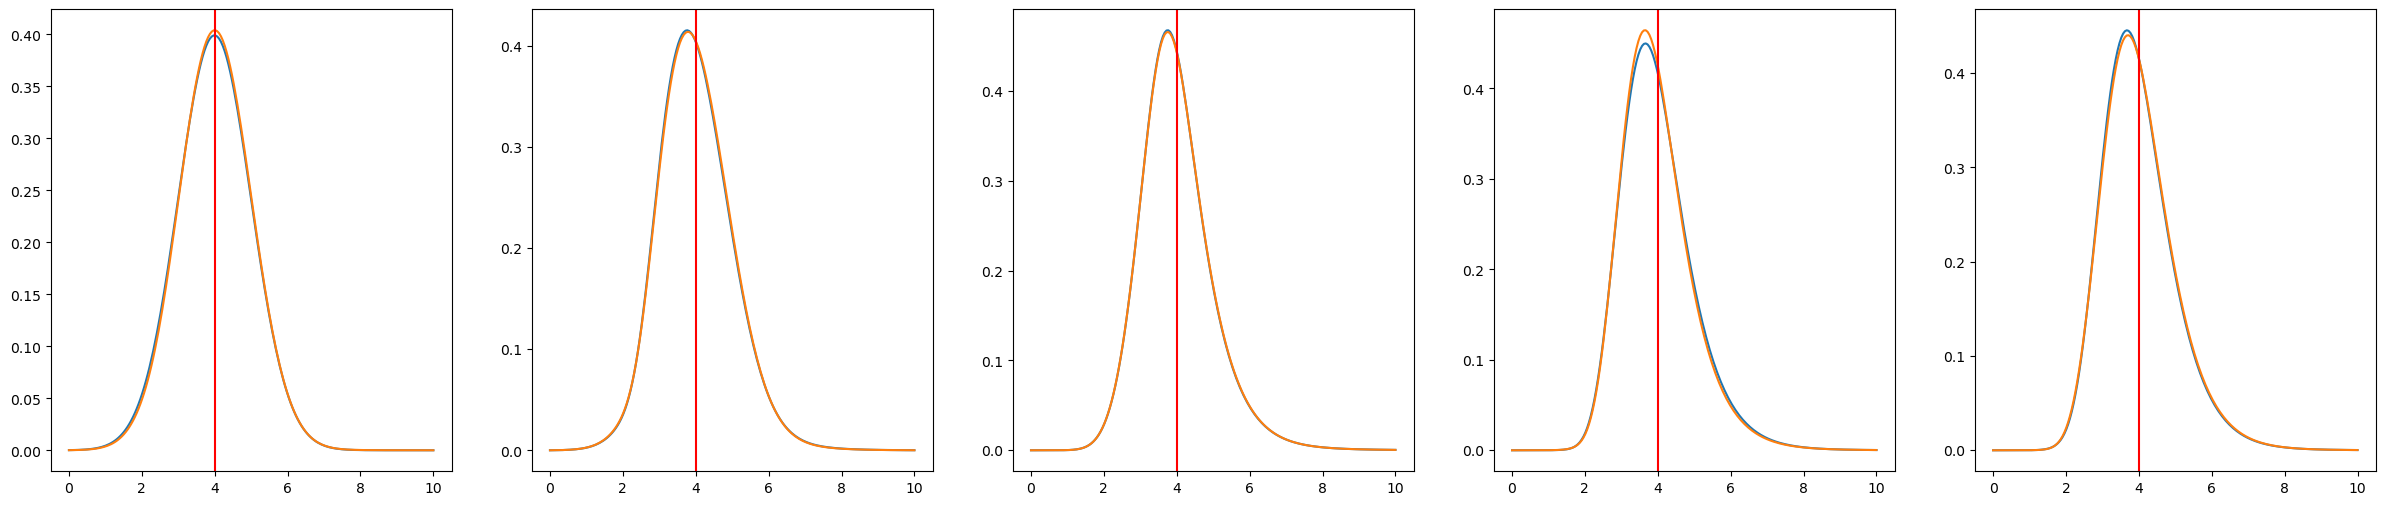

In [4]:
support = np.linspace(0, 10, 200)

def ensemble_comparison(distributions, weights, objective, mean, variance, support, figsize):
  fig, ax = plt.subplots(1, len(distributions), figsize=figsize)
  for i in range(len(distributions)):
    mod = EnsembleDistribution(distributions[i], weights[i], mean, variance)
    mod_draws = mod.rvs(size=10000)
    fit = EnsembleFitter(distributions[i], objective).fit(mod_draws)
    pdf = mod.pdf(support)
    ax[i].plot(support, pdf)
    ax[i].plot(support, fit.ensemble_distribution.pdf(support))
    ax[i].axvline(mean, color="red")

distributions = [["normal", "gumbel"],
                 ["normal", "gumbel"],
                 ["gamma", "fisk"],
                 ["invgamma", "lognormal", "fisk"],
                 ["gamma", "invgamma", "lognormal", "fisk"]]

weights = [[0.99, 0.01], [0.6, 0.4], [0.3, 0.7], [0.3, 0.5, 0.2], [0.2, 0.3, 0.3, 0.2]]

ensemble_comparison(distributions, weights, "KS", MEAN, VARIANCE, support, (30, 6))

# Diabetes

current combo: 
 nid            352898
location_id        66
year_id           1.0
sex            Female
age_start3         30
Name: 213592, dtype: object
num. rows: 393
FPG bounds: 2.4000001 21.799999
distributions and weights: {'gamma': 2.6445914683414467e-11, 'invgamma': 0.33383745600538883, 'lognormal': 6.000495772988786e-11, 'fisk': 0.6661625439081611}


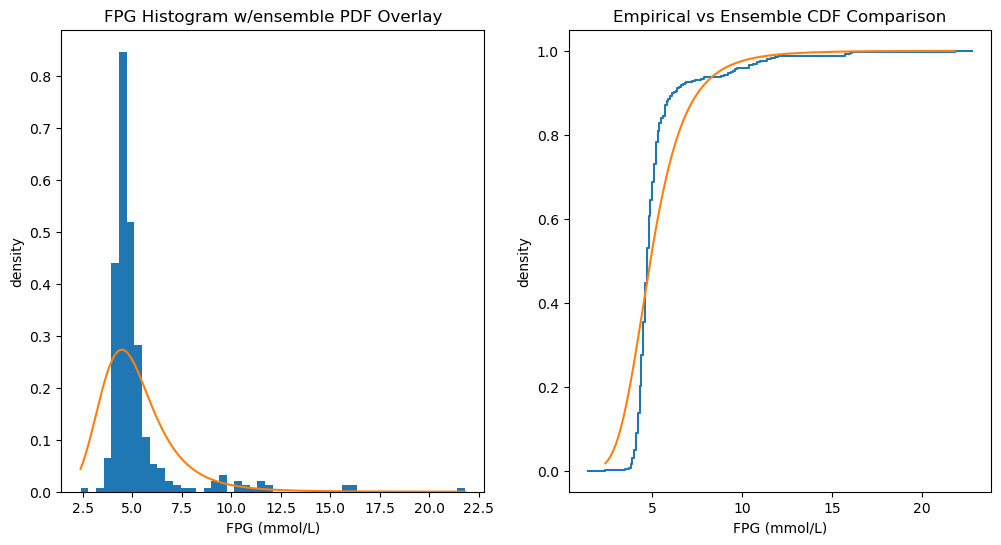

In [64]:
all_combos = data[['nid', 'location_id', 'year_id', 'sex', 'age_start3']].drop_duplicates()
num_combos = len(all_combos)
rand_idx = random.randint(0, num_combos)
rand_row = all_combos.iloc[rand_idx]
# print row identifiers before crashing
print("current combo: \n", rand_row)

filtered_df = data[(data['nid'] == rand_row["nid"]) &
                 (data['location_id'] == rand_row["location_id"]) &
                 (data['year_id'] == rand_row["year_id"]) &
                 (data['sex'] == rand_row["sex"]) &
                 (data['age_start3'] == rand_row["age_start3"])]

# add small jitter to deal with identical FPG values
fpg = filtered_df["fpg_mmol"].to_numpy()
# fpg = fpg + np.random.normal(loc=0, scale=0.00001, size=len(fpg))
# fit ensemble
distributions = ["gamma", "invgamma", "lognormal", "fisk"]
model = EnsembleFitter(distributions, "KS")
res = model.fit(fpg)
named_weights = {}
for i in range(len(distributions)):
  named_weights[distributions[i]] = res.weights[i]


# prepare matplotlib subplots and support
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
support = np.linspace(np.min(fpg), np.max(fpg), 1000)

# plot histogram vs fitted PDF
ax[0].hist(fpg, density=True, bins=50)
ax[0].plot(support, res.ensemble_distribution.pdf(support))
ax[0].set_xlabel("FPG (mmol/L)")
ax[0].set_ylabel("density")
ax[0].set_title("FPG Histogram w/ensemble PDF Overlay")

# plot eCDF vs fitted CDF
stats.ecdf(fpg).cdf.plot(ax[1])
ax[1].plot(support, res.ensemble_distribution.cdf(support))
# shows individual cdf fits but makes graph too busy
# for i in range(len(distributions)):
#   ax[1].plot(support, res.ensemble_distribution.my_objs[i].cdf(support), color="orange", alpha=0.25)
ax[1].set_xlabel("FPG (mmol/L)")
ax[1].set_ylabel("density")
ax[1].set_title("Empirical vs Ensemble CDF Comparison")

# various diagnostics
num_rows = len(filtered_df)
print("num. rows:", num_rows)
print("FPG bounds:", np.min(fpg), np.max(fpg))
print("distributions and weights:", named_weights)